In [1]:
# Pallative Care Data Analysis for Cancer hospitals
# Frederick Yeo
# 27 March 2025

In [2]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

%matplotlib inline

In [3]:
# Dataset
def load_data(filepath='PCH_Palliative_Care_HOSPITAL.csv'):
    print(f"Loading data from {filepath}...")
    df = pd.read_csv(filepath)
    
# Basic info
    print(f"Dataset shape: {df.shape}")
    print(f"Number of hospitals: {df['Facility Name'].nunique()}")
    print(f"Number of measures: {df['Measure ID'].nunique()}")
    
# Check for missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("Missing values present:")
        print(missing[missing > 0])
    else:
        print("No missing values in the dataset.")
    
# Measure descriptions
    print("\nMeasures in the dataset.")
    measures = df[['Measure ID', 'Measure Description']].drop_duplicates()
    for _, row in measures.iterrows():
        print(f"- {row['Measure ID']}: {row['Measure Description']}")
    
    return df

#Load data
df = load_data('PCH_Palliative_Care_HOSPITAL.csv')

Loading data from PCH_Palliative_Care_HOSPITAL.csv...
Dataset shape: (44, 15)
Number of hospitals: 11
Number of measures: 4
Missing values present:
Footnote    44
dtype: int64

Measures in the dataset.
- PCH-32: Proportion of patients who died from cancer receiving chemotherapy in the last 14 days of life
- PCH-33: Proportion of patients who died from cancer admitted to the ICU in the last 30 days of life
- PCH-34: Proportion of patients who died from cancer not admitted to hospice
- PCH-35: Proportion of patients who died from cancer admitted to hospice for less than 3 days


In [4]:
# Visualisation
plt.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['font.size'] = 12

In [5]:
# Pivot table for analysis
def create_pivot_table(df):
    
    # Unique identifies for hospitals
    df['Hospital_ID'] = df['Facility Name'] + ' (' + df['State'] + ')'
    
    # Pivot table, measures as columns
    pivot = df.pivot_table(
        index='Hospital_ID',
        columns="Measure ID",
        values='Rate')
    
    # Extra hospital info
    hospital_info = df.groupby('Hospital_ID').first()
    pivot['State'] = hospital_info['State']
    pivot['Total Cases'] = hospital_info['Total Cases']
    pivot['Facility Name'] = hospital_info['Facility Name'] 
                               
    # Measure ID Clarification
    pivot = pivot.rename(columns={
        'PCH-32': 'Last_Chemo',
        'PCH-33': 'ICU_Admit',
        'PCH-34': 'No_Hospice',
        'PCH-35': 'Short_Hospice'})   
    return pivot

# Create pivot table
pivot = create_pivot_table(df)   
print("\nPivot table (first few rows):")
print(pivot.head())
                                            


Pivot table (first few rows):
Measure ID                                          Last_Chemo  ICU_Admit  \
Hospital_ID                                                                 
CITY OF HOPE HELFORD CLINICAL RESEARCH HOSPITAL...         4.5       48.0   
DANA-FARBER CANCER INSTITUTE (MA)                          7.0       16.1   
FRED HUTCHINSON CANCER INSTITUTE (WA)                      4.5       21.8   
H LEE MOFFITT CANCER CENTER & RESEARCH INSTITUT...         2.6       36.3   
HOSPITAL OF THE FOX CHASE CANCER CENTER (PA)               4.1       34.7   

Measure ID                                          No_Hospice  Short_Hospice  \
Hospital_ID                                                                     
CITY OF HOPE HELFORD CLINICAL RESEARCH HOSPITAL...        41.1           31.4   
DANA-FARBER CANCER INSTITUTE (MA)                         33.3           22.3   
FRED HUTCHINSON CANCER INSTITUTE (WA)                     33.7           18.9   
H LEE MOFFITT CANCER CEN


=== Exploratory Data Analysis ===

Summary stats for each measure
            count       mean        std   min    25%   50%    75%   max
Measure ID                                                             
PCH-32       11.0   4.209091   1.626318   2.4   2.60   4.1   4.90   7.0
PCH-33       11.0  34.127273  11.993172  16.1  24.10  34.7  45.40  49.9
PCH-34       11.0  36.345455   7.208656  25.6  33.40  33.7  40.70  49.5
PCH-35       11.0  25.018182   4.534715  17.7  22.85  24.0  28.15  31.4

Range and standard deviation by measure:
Last_Chemo: Range = 4.6 (Min: 2.4, Max: 7.0), Std Dev = 1.6
ICU_Admit: Range = 33.8 (Min: 16.1, Max: 49.9), Std Dev = 12.0
No_Hospice: Range = 23.9 (Min: 25.6, Max: 49.5), Std Dev = 7.2
Short_Hospice: Range = 13.7 (Min: 17.7, Max: 31.4), Std Dev = 4.5

Correlation matrix:
Measure ID     Last_Chemo  ICU_Admit  No_Hospice  Short_Hospice
Measure ID                                                     
Last_Chemo       1.000000  -0.227292    0.205359      -0.0

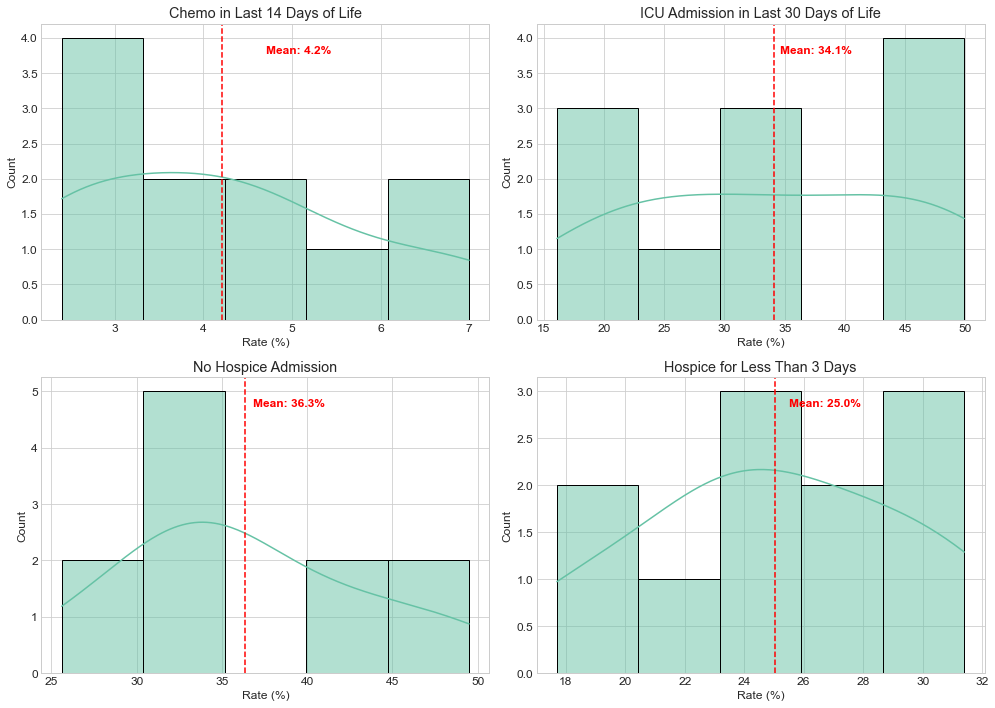

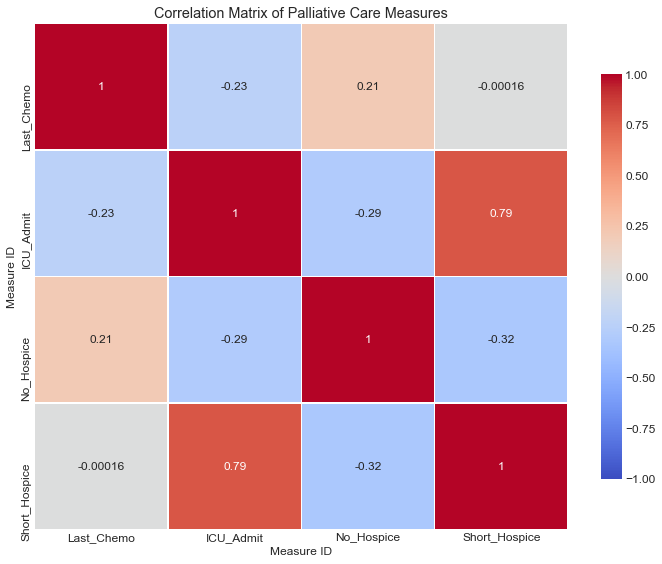

<Figure size 1008x576 with 0 Axes>

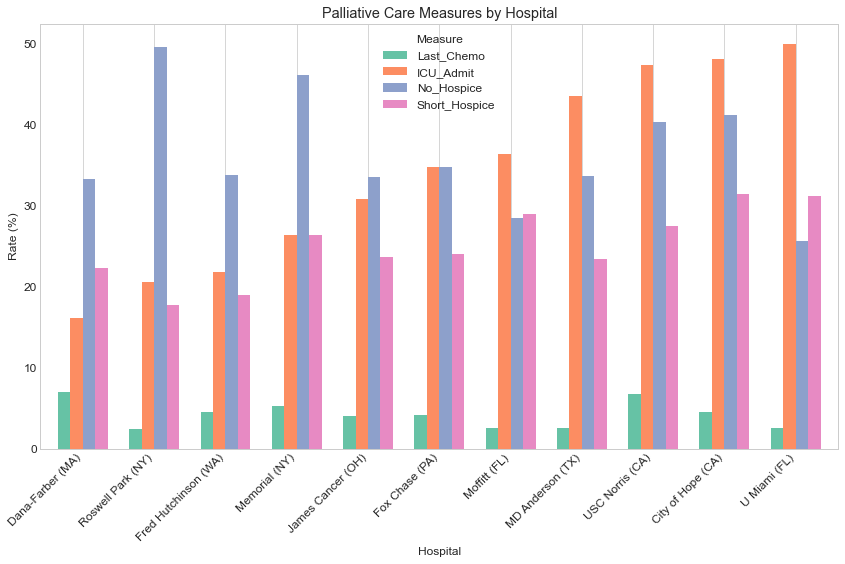

<Figure size 864x576 with 0 Axes>

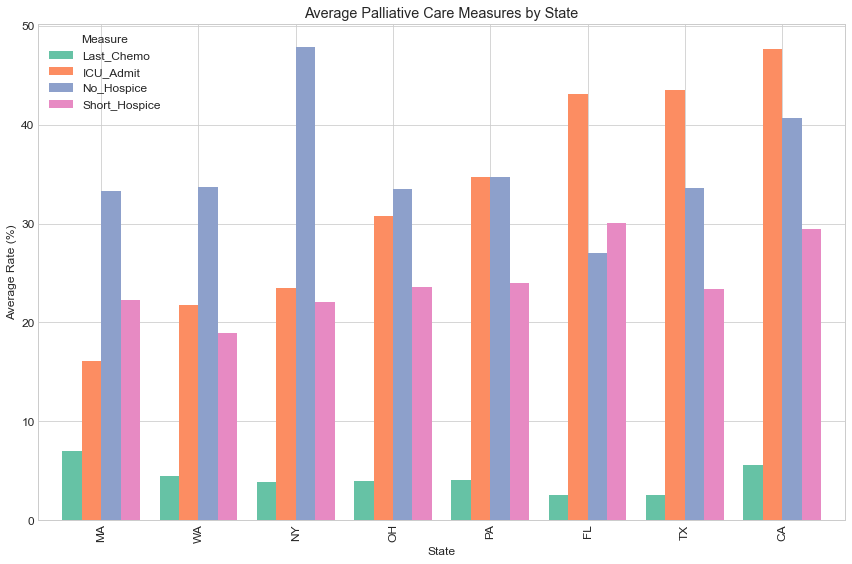

In [6]:
#Exploratory data analysis
def perform_eda(df, pivot):
    print("\n=== Exploratory Data Analysis ===")
    
    measure_stats = df.groupby('Measure ID')['Rate'].describe()
    print("\nSummary stats for each measure")
    print(measure_stats)
    
    print("\nRange and standard deviation by measure:")
    for measure in ['Last_Chemo', 'ICU_Admit', 'No_Hospice', 'Short_Hospice']:
        min_val = pivot[measure].min()
        max_val = pivot[measure].max()
        range_val = max_val - min_val
        std_val = pivot[measure].std()
        print(f"{measure}: Range = {range_val:.1f} (Min: {min_val:.1f}, Max: {max_val:.1f}), Std Dev = {std_val:.1f}")
        
    plt.figure(figsize=(14,10))
    
    measures = ['Last_Chemo', 'ICU_Admit', 'No_Hospice', 'Short_Hospice']
    titles = [
        'Chemo in Last 14 Days of Life',
        'ICU Admission in Last 30 Days of Life',
        'No Hospice Admission',
        'Hospice for Less Than 3 Days']
    
    for i, (measure, title) in enumerate(zip(measures, titles)):
        plt.subplot(2, 2, i+1)
        
        # Histogram + KDE
        sns.histplot(pivot[measure], kde=True)
        
        mean_val = pivot[measure].mean()
        plt.axvline(mean_val, color='red', linestyle='--')
        plt.text(mean_val + 0.5, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_val:.1f}%',
                 color='red', fontweight='bold')
        
        plt.title(title)
        plt.xlabel('Rate (%)')
        plt.ylabel('Count')
        
    plt.tight_layout()
    plt.savefig('measure_distributions.png')
    
    # Correlation Studies
    correlation_matrix = pivot[measures].corr()
    
    plt.figure(figsize=(10,8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
                linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Palliative Care Measures')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    
    print("\nCorrelation matrix:")
    print(correlation_matrix)
    
    # Comparison of hospitals
    plt.figure(figsize=(14, 8))

    # Sort by ICU admission rate
    sorted_pivot = pivot.sort_values('ICU_Admit')

    # Direct mapping with clean, readable abbreviations
    hospital_mapping = {
        'DANA-FARBER CANCER INSTITUTE (MA)': 'Dana-Farber (MA)',
        'ROSWELL PARK CANCER INSTITUTE (NY)': 'Roswell Park (NY)',
        'FRED HUTCHINSON CANCER INSTITUTE (WA)': 'Fred Hutchinson (WA)',
        'MEMORIAL HOSPITAL FOR CANCER AND ALLIED DISEASES (NY)': 'Memorial (NY)',
        'JAMES CANCER HOSPITAL & SOLOVE RESEARCH INSTITUTE (OH)': 'James Cancer (OH)',
        'HOSPITAL OF THE FOX CHASE CANCER CENTER (PA)': 'Fox Chase (PA)',
        'H LEE MOFFITT CANCER CENTER & RESEARCH INSTITUTE I (FL)': 'Moffitt (FL)',
        'UNIVERSITY OF TEXAS M D ANDERSON CANCER CENTER,THE (TX)': 'MD Anderson (TX)',
        'USC KENNETH NORRIS JR CANCER HOSPITAL (CA)': 'USC Norris (CA)',
        'CITY OF HOPE HELFORD CLINICAL RESEARCH HOSPITAL (CA)': 'City of Hope (CA)',
        'UNIV OF MIAMI HOSPITAL AND CLINICS-SYLVESTER COMPR (FL)': 'U Miami (FL)'}

     # Create a new dataframe with clean names
    sorted_pivot_clean = sorted_pivot.copy()
    sorted_pivot_clean.index = [hospital_mapping.get(hospital, hospital) for hospital in sorted_pivot.index]

    #Bar Chart
    ax = sorted_pivot_clean[measures].plot(kind='bar', width=0.7)


    plt.title('Palliative Care Measures by Hospital')
    plt.xlabel('Hospital')
    plt.ylabel('Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.legend(title='Measure')
    plt.tight_layout()
    plt.savefig('hospital_comparison.png', bbox_inches='tight')
    
    #State analysis
    state_avgs = pivot.groupby('State')[measures].mean()
    plt.figure(figsize=(12,8))
    
    state_avgs = state_avgs.sort_values('ICU_Admit')
    ax = state_avgs.plot(kind='bar', width=0.8)
    
    plt.title('Average Palliative Care Measures by State')
    plt.xlabel('State')
    plt.ylabel('Average Rate (%)')
    plt.legend(title='Measure')
    plt.tight_layout()
    plt.savefig('state_comparison.png')
    
    print("\nState averages:")
    print(state_avgs)
    
    return measure_stats, correlation_matrix


# Perform EDA
stats, corr = perform_eda(df, pivot)
    
    


=== Outlier Analysis ===

Outliers for Last_Chemo:
  DANA-FARBER CANCER INSTITUTE (MA): 7.0% (z-score: 1.72)
  USC KENNETH NORRIS JR CANCER HOSPITAL (CA): 6.7% (z-score: 1.53)

Outliers for ICU_Admit:
  DANA-FARBER CANCER INSTITUTE (MA): 16.1% (z-score: -1.50)

Outliers for No_Hospice:
  ROSWELL PARK CANCER INSTITUTE (NY): 49.5% (z-score: 1.82)

Outliers for Short_Hospice:
  ROSWELL PARK CANCER INSTITUTE (NY): 17.7% (z-score: -1.61)


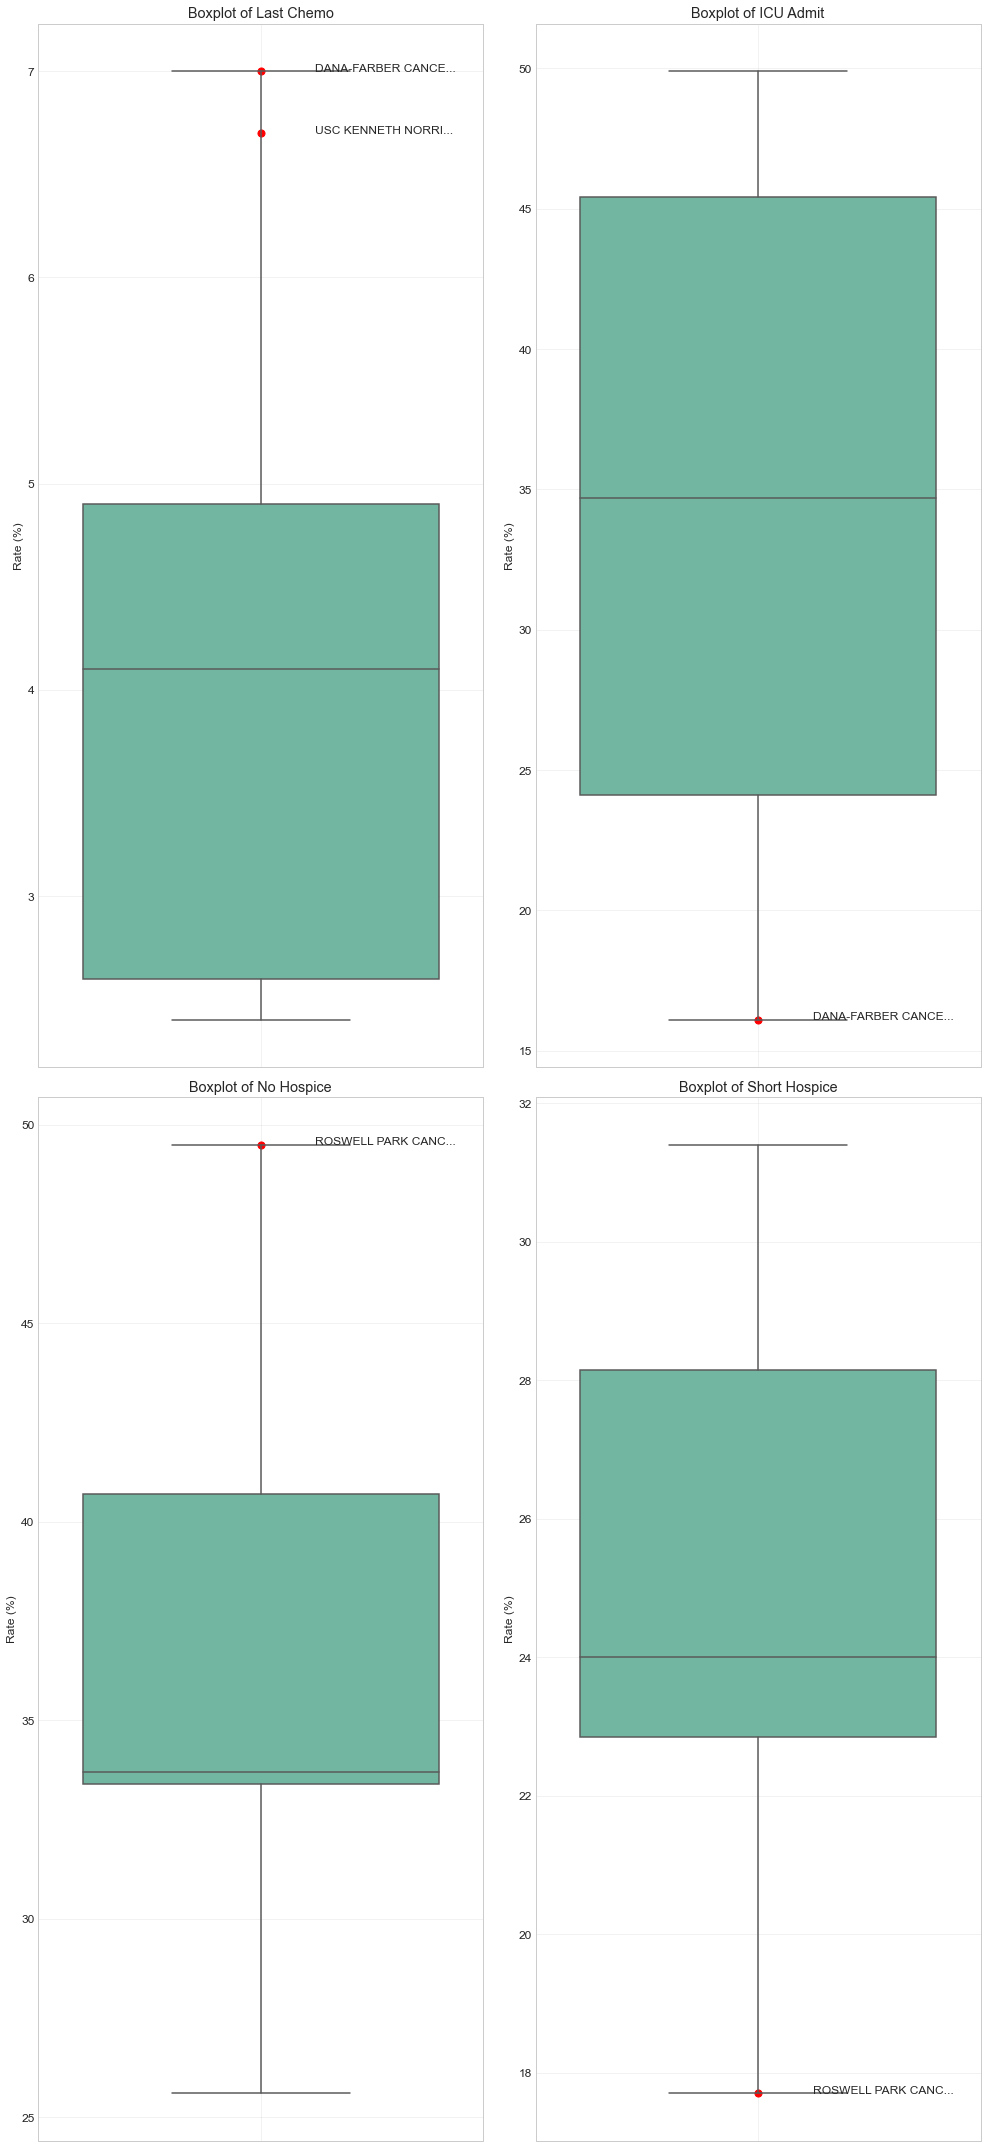

In [7]:
# Outlier Analysis
def identify_outliers(pivot):
    print("\n=== Outlier Analysis ===")
    measures = ['Last_Chemo', 'ICU_Admit', 'No_Hospice', 'Short_Hospice']
    
    # Z-scores for each measure
    z_scores = pd.DataFrame(index=pivot.index)
    
    for measure in measures:
        z_scores[measure] = (pivot[measure] - pivot[measure].mean()) / pivot[measure].std()
        
    # Identify outliers (|z| > 1.5)
    outliers = pd.DataFrame(index=pivot.index)
    
    for measure in measures:
        outliers[measure] = abs(z_scores[measure]) > 1.5
        
    # List of outlier hospitals for each measure
    outlier_hospitals = {}
    
    for measure in measures:
        outlier_idx = outliers.index[outliers[measure]]
        outlier_hospitals[measure] = []
        
        for idx in outlier_idx:
            outlier_hospitals[measure].append({
                'hospital': idx,
                'value': pivot.loc[idx, measure],
                'z_score': z_scores.loc[idx, measure]})
            
    # Print outliers
    for measure in measures:
        print(f"\nOutliers for {measure}:")
        if outlier_hospitals[measure]:
            for hospital in outlier_hospitals[measure]:
                print(f"  {hospital['hospital']}: {hospital['value']:.1f}% (z-score: {hospital['z_score']:.2f})")
        else:
            print("No outliers present")
            
    # Outlier boxplots
    plt.figure(figsize=(14,30))
    
    for i, measure in enumerate(measures):
        plt.subplot(2, 2, i+1)
        
        sns.boxplot(y=pivot[measure])
        
        outlier_values = [item['value'] for item in outlier_hospitals[measure]]
        if outlier_values:
            plt.scatter(np.zeros_like(outlier_values), outlier_values, color='red', s=50)
            
            for item in outlier_hospitals[measure]:
                hospital_name = item['hospital'].split('(')[0].strip()
                if len(hospital_name) > 20:
                    hospital_name = hospital_name[:17] + "..."
                    
                plt.annotate(
                    hospital_name,
                    (0.1, item['value']),
                    textcoords="offset points",
                    xytext=(10, 0),
                    ha='left')
                    
        plt.title(f"Boxplot of {measure.replace('_', ' ')}")
        plt.ylabel('Rate (%)')
        plt.grid(True, alpha=0.3)
                  
    plt.tight_layout()
    plt.savefig('outlier_analysis.png')
                  
    return outlier_hospitals

# Identify outliers
outliers = identify_outliers(pivot)
        


=== Predictive Modelling ===

Model Evaluation:
Mean Absolute Error: 2.20
R²: 0.67

Model Coefficients (Standardized):
      Feature  Coefficient  Abs_Coefficient
1   ICU_Admit     3.433860         3.433860
0  Last_Chemo     0.899465         0.899465
2  No_Hospice    -0.582720         0.582720

Model Formula: Short_Hospice = 25.018 + 0.899xLast_Chemo + 3.434xICU_Admit + -0.583xNo_Hospice

Predictions for each hospital:
                                                                                             Hospital  \
Hospital_ID                                                                                             
MEMORIAL HOSPITAL FOR CANCER AND ALLIED DISEASE...  MEMORIAL HOSPITAL FOR CANCER AND ALLIED DISEAS...   
UNIVERSITY OF TEXAS M D ANDERSON CANCER CENTER,...  UNIVERSITY OF TEXAS M D ANDERSON CANCER CENTER...   
H LEE MOFFITT CANCER CENTER & RESEARCH INSTITUT...  H LEE MOFFITT CANCER CENTER & RESEARCH INSTITU...   
FRED HUTCHINSON CANCER INSTITUTE (WA)              

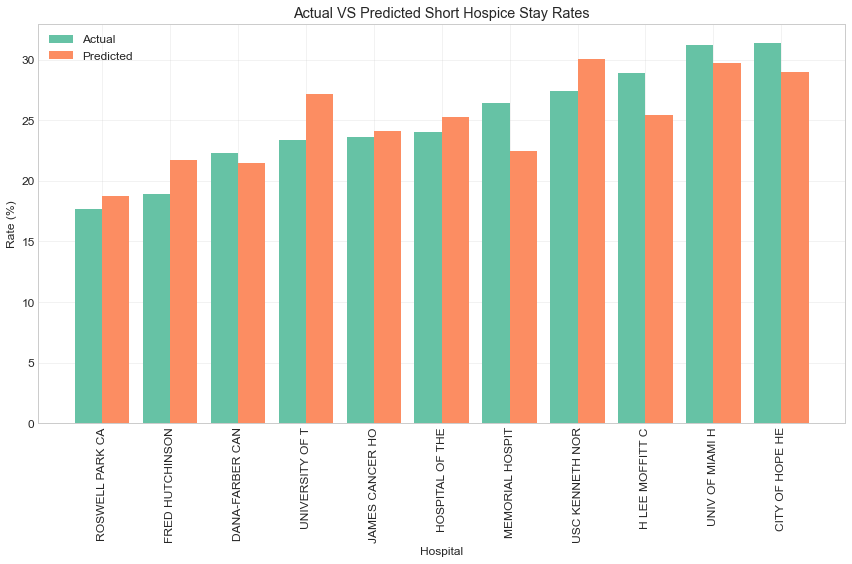

In [8]:
# Predictive model
def build_predictive_model(pivot):
    print("\n=== Predictive Modelling ===")
    
    X = pivot[['Last_Chemo', 'ICU_Admit', 'No_Hospice']]
    y = pivot['Short_Hospice']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_scaled, y)
    
    y_pred = model.predict(X_scaled)
    
    # Model Evaluation
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"\nModel Evaluation:")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    
    # Coefficients
    coefficients = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_,
        'Abs_Coefficient': np.abs(model.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\nModel Coefficients (Standardized):")
    print(coefficients)
    
    # Model Formula
    b0 = model.intercept_
    b1, b2, b3 = model.coef_
    
    print(f"\nModel Formula: Short_Hospice = {b0:.3f} + {b1:.3f}xLast_Chemo + {b2:.3f}xICU_Admit + {b3:.3f}xNo_Hospice")
    
    # DataFame with actual vs predicted values
    prediction_df = pd.DataFrame({
        'Hospital': pivot.index,
        'Actual': y,
        'Predicted': y_pred,
        'Error': np.abs(y - y_pred),
        'Error_Percent': 100 * np.abs(y - y_pred) / y
    })
    
    print("\nPredictions for each hospital:")
    print(prediction_df[['Hospital', 'Actual', 'Predicted', 'Error']].sort_values('Error', ascending=False))
    
    plt.figure(figsize=(12,8))
    
    prediction_df = prediction_df.sort_values('Actual')
    
    plt.bar(np.arange(len(prediction_df)) - 0.2, prediction_df['Actual'], width=0.4, label='Actual')
    plt.bar(np.arange(len(prediction_df)) + 0.2, prediction_df['Predicted'], width=0.4, label='Predicted')
    
    plt.title('Actual VS Predicted Short Hospice Stay Rates')
    plt.xlabel('Hospital')
    plt.ylabel('Rate (%)')
    plt.xticks(np.arange(len(prediction_df)), [h.split('(')[0].strip()[:15] for h in prediction_df['Hospital']],
               rotation=90)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('prediction_results.png')
    
    return {
        'model': model,
        'scaler': scaler,
        'coefficients': coefficients,
        'predictions': prediction_df,
        'mae': mae,
        'r2': r2,
        'formula': {
            'intercept': b0,
            'last_chemo_coef': b1,
            'icu_admit_coef': b2,
            'no_hospice_coef': b3
        }
    }
    
    
# Build predictive model
model_results = build_predictive_model(pivot)  


=== Intervention Simulation ===

Best performing hospital on ICU admission: DANA-FARBER CANCER INSTITUTE (MA)
Best ICU admission rate: 16.1%

Simulation results (sorted by potential improvement):
                                                                                        Facility_Name  \
Hospital_ID                                                                                             
UNIV OF MIAMI HOSPITAL AND CLINICS-SYLVESTER CO...  UNIV OF MIAMI HOSPITAL AND CLINICS-SYLVESTER C...   
CITY OF HOPE HELFORD CLINICAL RESEARCH HOSPITAL...    CITY OF HOPE HELFORD CLINICAL RESEARCH HOSPITAL   
USC KENNETH NORRIS JR CANCER HOSPITAL (CA)                      USC KENNETH NORRIS JR CANCER HOSPITAL   
UNIVERSITY OF TEXAS M D ANDERSON CANCER CENTER,...  UNIVERSITY OF TEXAS M D ANDERSON CANCER CENTER...   
H LEE MOFFITT CANCER CENTER & RESEARCH INSTITUT...  H LEE MOFFITT CANCER CENTER & RESEARCH INSTITU...   
HOSPITAL OF THE FOX CHASE CANCER CENTER (PA)                  HOSPIT

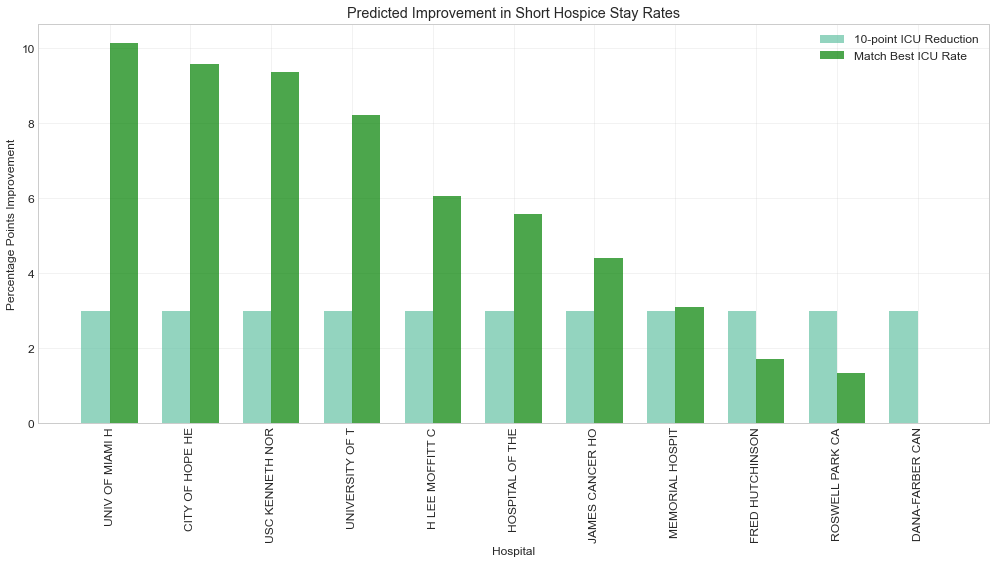

In [9]:
# Simulate the effect of interventions
def simulate_interventions(pivot, model_results):

    print("\n=== Intervention Simulation ===")
    
    # Extract model components
    model = model_results['model']
    scaler = model_results['scaler']
    b0 = model_results['formula']['intercept']
    b1 = model_results['formula']['last_chemo_coef']
    b2 = model_results['formula']['icu_admit_coef']
    b3 = model_results['formula']['no_hospice_coef']
    
    # Create a copy of the data
    simulation_df = pivot.copy()
    
    # Calculate baseline predictions
    X_baseline = simulation_df[['Last_Chemo', 'ICU_Admit', 'No_Hospice']]
    X_baseline_scaled = scaler.transform(X_baseline)
    baseline_predictions = model.predict(X_baseline_scaled)
    
    # Scenario 1: Reduce ICU admission by 10 percentage points
    simulation_df['ICU_Reduced_10'] = simulation_df['ICU_Admit'] - 10
    simulation_df.loc[simulation_df['ICU_Reduced_10'] < 0, 'ICU_Reduced_10'] = 0
    
    X_scenario1 = simulation_df[['Last_Chemo', 'ICU_Reduced_10', 'No_Hospice']]
    # Need to handle the column name change for the scaler
    X_scenario1_renamed = X_scenario1.rename(columns={'ICU_Reduced_10': 'ICU_Admit'})
    X_scenario1_scaled = scaler.transform(X_scenario1_renamed)
    scenario1_predictions = model.predict(X_scenario1_scaled)
    
    # Scenario 2: All hospitals match the best performer's ICU rate
    best_icu_rate = pivot['ICU_Admit'].min()
    best_performer = pivot.loc[pivot['ICU_Admit'].idxmin()]
    
    simulation_df['ICU_Best'] = best_icu_rate
    
    X_scenario2 = simulation_df[['Last_Chemo', 'ICU_Best', 'No_Hospice']]
    # Need to handle the column name change for the scaler
    X_scenario2_renamed = X_scenario2.rename(columns={'ICU_Best': 'ICU_Admit'})
    X_scenario2_scaled = scaler.transform(X_scenario2_renamed)
    scenario2_predictions = model.predict(X_scenario2_scaled)
    
    # Create results DataFrame
    results = pd.DataFrame({
        'Hospital': simulation_df.index,
        'Facility_Name': simulation_df['Facility Name'],
        'Original_ICU': simulation_df['ICU_Admit'],
        'Baseline_Short_Hospice': baseline_predictions,
        'Reduced_ICU_10pts': simulation_df['ICU_Reduced_10'],
        'Scenario1_Short_Hospice': scenario1_predictions,
        'Scenario1_Improvement': baseline_predictions - scenario1_predictions,
        'Best_ICU_Rate': simulation_df['ICU_Best'],
        'Scenario2_Short_Hospice': scenario2_predictions,
        'Scenario2_Improvement': baseline_predictions - scenario2_predictions
    })
    
    # Sort by potential improvement in Scenario 2
    results = results.sort_values('Scenario2_Improvement', ascending=False)
    
    print(f"\nBest performing hospital on ICU admission: {best_performer.name}")
    print(f"Best ICU admission rate: {best_icu_rate:.1f}%")
    
    print("\nSimulation results (sorted by potential improvement):")
    print(results[['Facility_Name', 'Original_ICU', 'Scenario1_Improvement', 'Scenario2_Improvement']])
    
    # Average improvements
    avg_improvement_scenario1 = results['Scenario1_Improvement'].mean()
    avg_improvement_scenario2 = results['Scenario2_Improvement'].mean()
    
    print(f"\nAverage improvement with 10-point ICU reduction: {avg_improvement_scenario1:.2f} percentage points")
    print(f"Average improvement matching best ICU rate: {avg_improvement_scenario2:.2f} percentage points")
    
    # Simulation results
    plt.figure(figsize=(14, 8))
    
    hospital_names = [name.split('(')[0].strip()[:15] for name in results['Facility_Name']]
    
    # Plot improvements
    x = np.arange(len(results))
    width = 0.35
    
    plt.bar(x - width/2, results['Scenario1_Improvement'], width=width,
            label='10-point ICU Reduction', alpha=0.7)
    plt.bar(x + width/2, results['Scenario2_Improvement'], width=width,
            label='Match Best ICU Rate', alpha=0.7, color='green')
    
    plt.title('Predicted Improvement in Short Hospice Stay Rates')
    plt.xlabel('Hospital')
    plt.ylabel('Percentage Points Improvement')
    plt.xticks(x, hospital_names, rotation=90)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('simulation_results.png')
    
    
# Simulate interventions
simulation = simulate_interventions(pivot, model_results)


=== Hospital Rankings ===

Hospital rankings (the lower the better):
                                                                                        Facility_Name  \
Hospital_ID                                                                                             
ROSWELL PARK CANCER INSTITUTE (NY)                                      ROSWELL PARK CANCER INSTITUTE   
FRED HUTCHINSON CANCER INSTITUTE (WA)                                FRED HUTCHINSON CANCER INSTITUTE   
H LEE MOFFITT CANCER CENTER & RESEARCH INSTITUT...  H LEE MOFFITT CANCER CENTER & RESEARCH INSTITU...   
JAMES CANCER HOSPITAL & SOLOVE RESEARCH INSTITU...  JAMES CANCER HOSPITAL & SOLOVE RESEARCH INSTITUTE   
UNIVERSITY OF TEXAS M D ANDERSON CANCER CENTER,...  UNIVERSITY OF TEXAS M D ANDERSON CANCER CENTER...   
HOSPITAL OF THE FOX CHASE CANCER CENTER (PA)                  HOSPITAL OF THE FOX CHASE CANCER CENTER   
DANA-FARBER CANCER INSTITUTE (MA)                                        DANA-FARBER CANCE

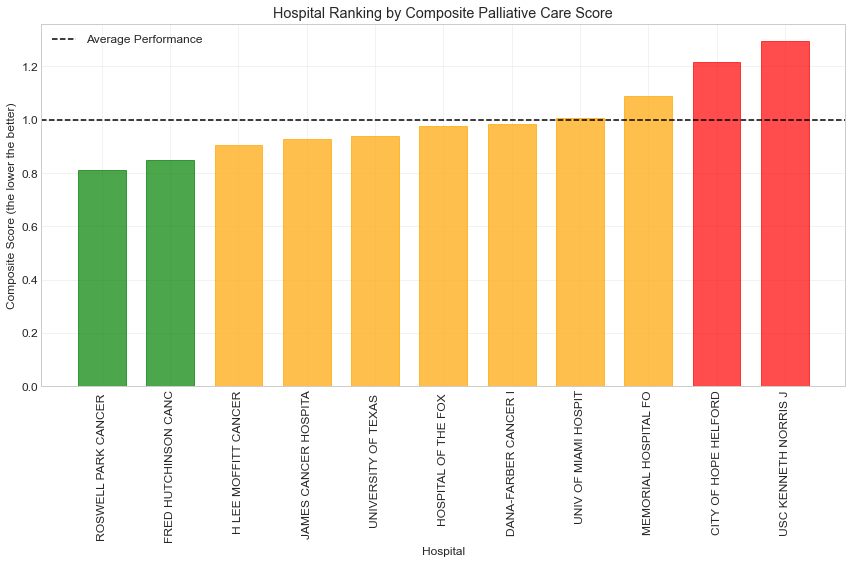

In [10]:
# Hospital rankings by composite scoring
def rank_hospitals(pivot):
    
    print("\n=== Hospital Rankings ===")
    
    # Define weights
    weights = {
        'Last_Chemo': 0.25,
        'ICU_Admit': 0.25,
        'No_Hospice': 0.25,
        'Short_Hospice': 0.25
    }
    
    # Normalized scores
    measures = list(weights.keys())
    norm_scores = pd.DataFrame(index=pivot.index)
    
    for measure in measures:
        # Normalize by dividing by mean (lower is better for all metrics)
        avg = pivot[measure].mean()
        norm_scores[measure] = pivot[measure] / avg
    
    # Weighted composite score
    composite_scores = pd.DataFrame(index=pivot.index)
    composite_scores['Composite_Score'] = 0
    
    for measure, weight in weights.items():
        composite_scores['Composite_Score'] += norm_scores[measure] * weight
    
    # Hospital information
    composite_scores['Facility_Name'] = pivot['Facility Name']
    composite_scores['State'] = pivot['State']
    composite_scores['Total_Cases'] = pivot['Total Cases']
    
    # Composite score sorting (ascending as lower is better)
    ranked_hospitals = composite_scores.sort_values('Composite_Score')
    
    print("\nHospital rankings (the lower the better):")
    print(ranked_hospitals[['Facility_Name', 'State', 'Composite_Score', 'Total_Cases']])
    
    # Rankings
    plt.figure(figsize=(12, 8))
    

    hospital_names = [name[:20] for name in ranked_hospitals['Facility_Name']]
    
    # Bar chart with coloring based on score
    bars = plt.bar(hospital_names, ranked_hospitals['Composite_Score'], width=0.7, alpha=0.7)
    
    # Color bars based on score
    for i, bar in enumerate(bars):
        if ranked_hospitals['Composite_Score'].iloc[i] < 0.9:
            bar.set_color('green')
        elif ranked_hospitals['Composite_Score'].iloc[i] > 1.1:
            bar.set_color('red')
        else:
            bar.set_color('orange')
    
    plt.title('Hospital Ranking by Composite Palliative Care Score')
    plt.xlabel('Hospital')
    plt.ylabel('Composite Score (the lower the better)')
    plt.axhline(y=1.0, color='black', linestyle='--', label='Average Performance')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('hospital_ranking.png')
    
    return ranked_hospitals

# Rank hospitals
rankings = rank_hospitals(pivot)